In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.models import Sequential
import keras
from tensorflow.keras.optimizers import RMSprop
import cv2
import os
import shutil

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.optimizers import Adamax, Adam, RMSprop
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

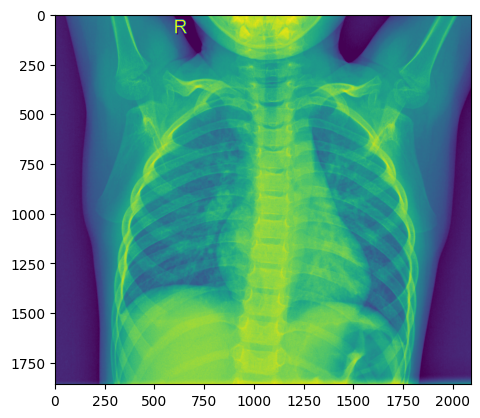

In [3]:
img = cv2.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg', cv2.COLOR_RGB2BGR)
plt.imshow(img)

In [4]:
img.shape

(1858, 2090)

In [6]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm  

def get_train_augs():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.2),
        A.Blur(blur_limit=(3, 7), p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
    ], p=1.0)

def augment_and_save(image_path, save_dir, augmentations, num_copies=2):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0  
    
    filename = os.path.basename(image_path).split('.')[0]  

    for i in range(num_copies):
        augmented = augmentations(image=image)
        aug_image = (augmented['image'] * 255).astype(np.uint8) 
        
        save_path = os.path.join(save_dir, f"{filename}_aug_{i}.jpeg")
        cv2.imwrite(save_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

def balance_normal_class(original_data_dir, new_data_dir, num_augment_per_image=2):
    original_normal_path = os.path.join(original_data_dir, "NORMAL")
    pneumonia_path = os.path.join(original_data_dir, "PNEUMONIA")

    new_train_dir = os.path.join(new_data_dir, "train")
    new_normal_dir = os.path.join(new_train_dir, "NORMAL")
    new_pneumonia_dir = os.path.join(new_train_dir, "PNEUMONIA")

    os.makedirs(new_normal_dir, exist_ok=True)
    os.makedirs(new_pneumonia_dir, exist_ok=True)

    normal_images = [os.path.join(original_normal_path, img) for img in os.listdir(original_normal_path) if img.endswith(('.jpeg', '.png', '.jpg'))]
    for img_path in normal_images:
        shutil.copy(img_path, new_normal_dir)

    pneumonia_images = [os.path.join(pneumonia_path, img) for img in os.listdir(pneumonia_path) if img.endswith(('.jpeg', '.png', '.jpg'))]
    for img_path in pneumonia_images:
        shutil.copy(img_path, new_pneumonia_dir)

    pneumonia_count = len(pneumonia_images)
    normal_count = len(normal_images)

    images_needed = pneumonia_count - normal_count 
    
    if images_needed <= 0:
        print("Dataset is already balanced!")
        return

    print(f"Balancing 'NORMAL' class by adding {images_needed} images...")

    for img_path in tqdm(normal_images, desc="Augmenting NORMAL class"):
        augment_and_save(img_path, new_normal_dir, get_train_augs(), num_copies=num_augment_per_image)

original_data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
new_data_dir = "/kaggle/working/chest_xray_balanced" 
balance_normal_class(original_data_dir, new_data_dir, num_augment_per_image=2)

print("Augmented images saved in:", new_data_dir)

Balancing 'NORMAL' class by adding 2534 images...


Augmenting NORMAL class: 100%|██████████| 1341/1341 [09:03<00:00,  2.47it/s]

Augmented images saved in: /kaggle/working/chest_xray_balanced


In [7]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_dataset_from_directory(data_dir, original_test_dir, target_size=(224, 224), batch_size=32, validation_split=0.2):
    train_dir = os.path.join(data_dir, 'train')  
    test_dir = os.path.join(data_dir, 'test')  

    if not os.path.exists(train_dir):
        print(f"Train directory not found: {train_dir}")
        return None, None, None

    if not os.path.exists(test_dir):
        print(f"Test directory not found: Using original test directory.")
        test_dir = original_test_dir  

    datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

    train_dataset = datagen.flow_from_directory(
        train_dir,  
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training' 
    )

    val_dataset = datagen.flow_from_directory(
        train_dir,  
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'  
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_dataset = test_datagen.flow_from_directory(
        test_dir,  
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_dataset, val_dataset, test_dataset

data_dir = "/kaggle/working/chest_xray_balanced"
original_test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

train_dataset, val_dataset, test_dataset = load_dataset_from_directory(data_dir, original_test_dir)

Test directory not found: Using original test directory.
Found 6319 images belonging to 2 classes.
Found 1579 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
import os

train_normal = len(os.listdir("/kaggle/working/chest_xray_balanced/train/NORMAL"))
train_pneumonia = len(os.listdir("/kaggle/working/chest_xray_balanced/train/PNEUMONIA"))

print(f"Balanced Training Data:")
print(f"NORMAL: {train_normal} images")
print(f"PNEUMONIA: {train_pneumonia} images")

Balanced Training Data:
NORMAL: 4023 images
PNEUMONIA: 3875 images


In [9]:
train_dataset.image_shape
val_dataset.image_shape
test_dataset.image_shape

(224, 224, 3)

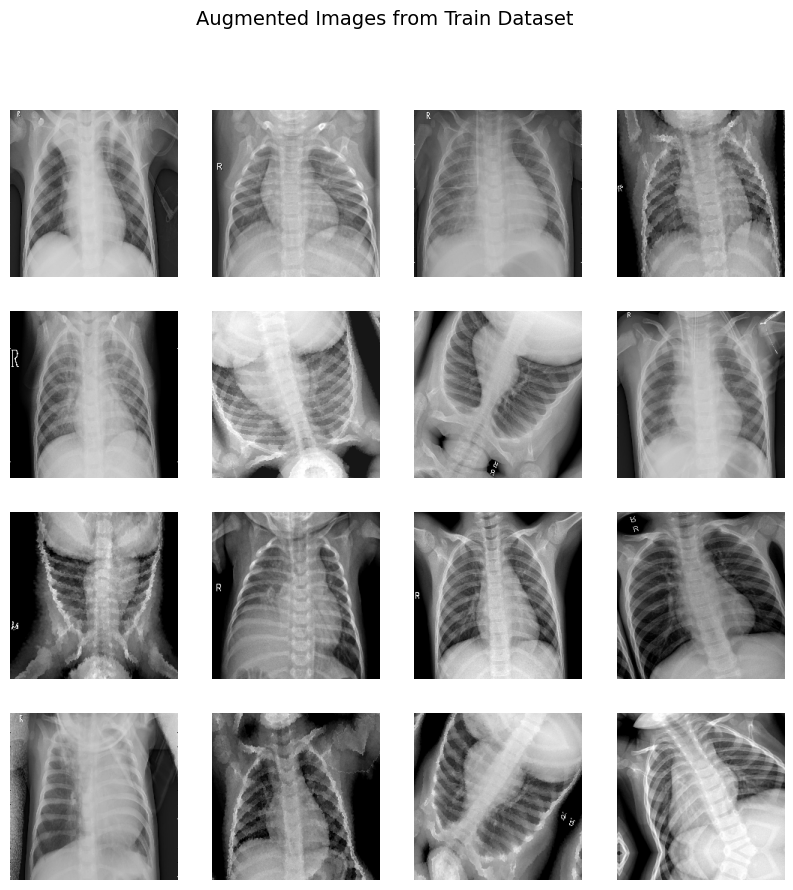

In [10]:
import matplotlib.pyplot as plt

img_batch, label_batch = next(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img_batch[i]) 
    plt.axis('off')

plt.suptitle("Augmented Images from Train Dataset", fontsize=14)
plt.show()

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [27]:
image_size = (224, 224)
channels = 3
image_shape = (image_size[0], image_size[1], channels)
class_count = 1

model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=image_shape),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(class_count, activation='sigmoid')
    ])

model.compile(optimizer=Adamax(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,185,601 (42.67 MB)

 Trainable params: 11,185,601 (42.67 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(monitor='val_loss',mode='min',patience=7)

In [29]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,  
    epochs=30, 
    callbacks=[early_stopping]
)

Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 77s 362ms/step - accuracy: 0.7415 - loss: 0.5206 - val_accuracy: 0.9392 - val_loss: 0.1594
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 72s 354ms/step - accuracy: 0.9410 - loss: 0.1618 - val_accuracy: 0.9607 - val_loss: 0.1169
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 72s 351ms/step - accuracy: 0.9569 - loss: 0.1160 - val_accuracy: 0.9639 - val_loss: 0.1073
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 72s 356ms/step - accuracy: 0.9633 - loss: 0.0976 - val_accuracy: 0.9531 - val_loss: 0.1240
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 76s 372ms/step - accuracy: 0.9739 - loss: 0.0795 - val_accuracy: 0.9544 - val_loss: 0.1298
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 82s 403ms/step - accuracy: 0.9745 - loss: 0.0692 - val_accuracy: 0.9690 - val_loss: 0.0911
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 86s 420ms/step - accuracy: 0.9787 - loss: 0.0587 - val_accuracy: 0.9696 - val_loss: 0.0911
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 84s 412ms/step - accuracy: 0.9797 - loss: 0

In [30]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Val Accuracy: {val_acc:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.9696 - loss: 0.1485
Val Accuracy: 0.9671


In [31]:
final_train_acc = history.history['accuracy'][-1] 
print(f"Final Training Accuracy: {final_train_acc:.4f}")

Final Training Accuracy: 0.9905


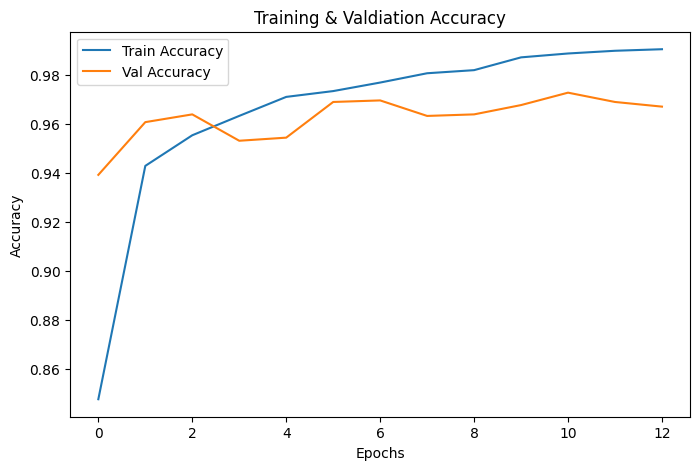

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Valdiation Accuracy")
plt.legend()
plt.show()